Epoch [1/5] | D Loss: 0.3001 | G Loss: 5.9330
Epoch [2/5] | D Loss: 0.0029 | G Loss: 6.8348
Epoch [3/5] | D Loss: 0.0001 | G Loss: 9.2540
Epoch [4/5] | D Loss: 0.0020 | G Loss: 7.1784
Epoch [5/5] | D Loss: 0.0000 | G Loss: 10.2156


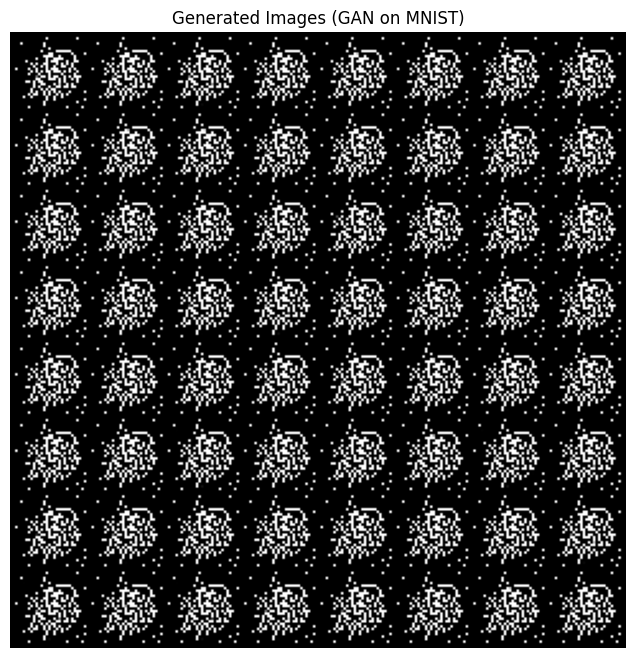

In [2]:
# Experiment 10 - Simple GAN on MNIST (Fast Version)

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt

# Hyperparameters
batch_size = 128
z_dim = 100
lr = 0.0002
epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data (MNIST)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
dataset = datasets.MNIST(root="data", train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Generator
class Generator(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 28*28),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        return img.view(-1, 1, 28, 28)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img.view(img.size(0), -1))

# Initialize models
G = Generator(z_dim).to(device)
D = Discriminator().to(device)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=lr)
optimizer_D = optim.Adam(D.parameters(), lr=lr)

# Training loop
for epoch in range(epochs):
    for i, (imgs, _) in enumerate(dataloader):
        real_imgs = imgs.to(device)
        batch_size = real_imgs.size(0)

        # Labels
        valid = torch.ones(batch_size, 1, device=device)
        fake = torch.zeros(batch_size, 1, device=device)

        # ---------------------
        #  Train Generator
        # ---------------------
        optimizer_G.zero_grad()
        z = torch.randn(batch_size, z_dim, device=device)
        gen_imgs = G(z)
        g_loss = criterion(D(gen_imgs), valid)
        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()
        real_loss = criterion(D(real_imgs), valid)
        fake_loss = criterion(D(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

# Generate final images
G.eval()
with torch.no_grad():
    z = torch.randn(64, z_dim, device=device)
    gen_imgs = G(z).cpu()
    grid = vutils.make_grid(gen_imgs, nrow=8, normalize=True)
    plt.figure(figsize=(8,8))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis("off")
    plt.title("Generated Images (GAN on MNIST)")
    plt.show()
